<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


In [2]:
%run 'utils.py'

In [3]:
import argparse
import os
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import ExponentialLR
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from utils import *

PRINT_INTERVAL = 2_000_000
PATH = "datasets"
cuda = torch.cuda.is_available()


# Training *from scratch* of the model

In [3]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(
            bsize, -1
        )  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False, plot=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda:  # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer and plot:
            loss_plot.update(avg_loss.val)
        # print info
        # if i % PRINT_INTERVAL == 0:
        #     print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #           'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #           'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #            "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #            top1=avg_top1_acc, top5=avg_top5_acc))
        #     if optimizer and plot:
        #         loss_plot.plot()

    # Print summary
    # print('\n===============> Total time {batch_time:d}s\t'
    #       'Avg loss {loss.avg:.4f}\t'
    #       'Avg Prec@1 {top1.avg:5.2f} %\t'
    #       'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
    #        batch_time=int(avg_batch_time.sum), loss=avg_loss,
    #        top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False, scheduler=False, save_name=None, ax=None):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    if scheduler:
        scheduler = ExponentialLR(optimizer, gamma=0.95)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n==== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(
            test, model, criterion, cuda=cuda
        )
        if scheduler:
            scheduler.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    plot.plot(save_name)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [01:17<00:00,  5.15s/it]


<Figure size 640x480 with 0 Axes>

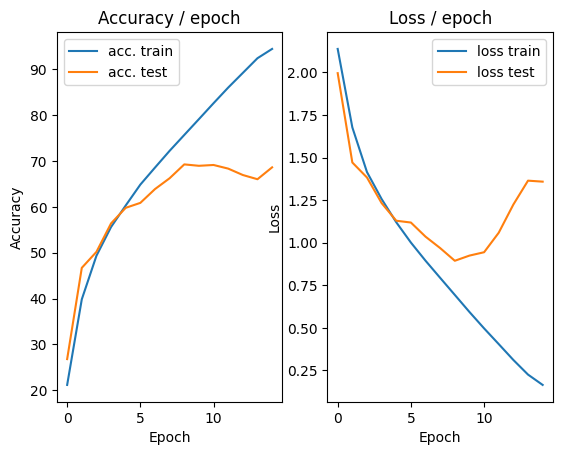

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

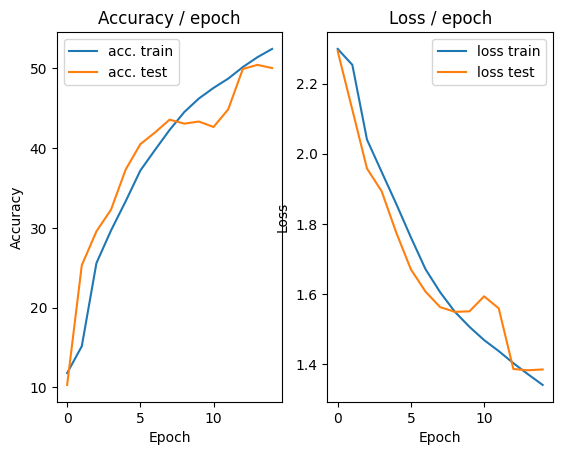

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [02:11<00:00,  8.79s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

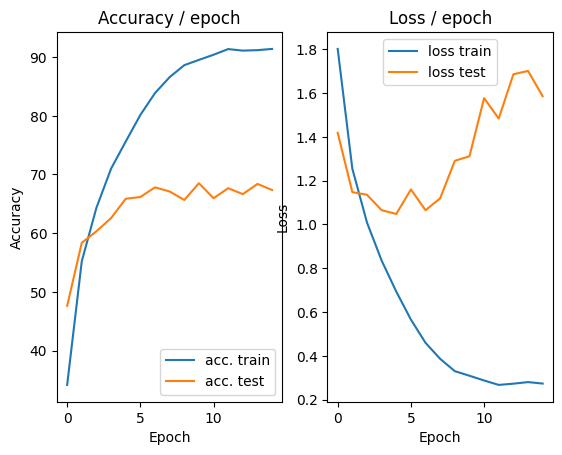

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 15/15 [02:14<00:00,  8.93s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

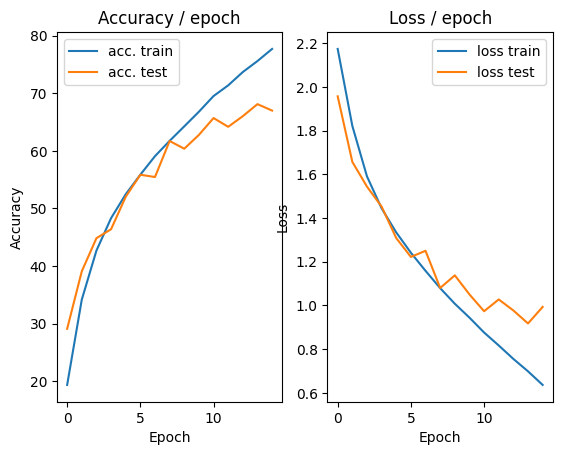

<Figure size 640x480 with 0 Axes>

In [4]:
main(128, 0.1, epochs=15, cuda=cuda, save_name="batch128_lr0_1")
main(128, 0.01, epochs=15, cuda=cuda, save_name="batch128_lr0_01")
main(32, 0.1, epochs=15, cuda=cuda, save_name="batch32_lr0_1")
main(32, 0.01, epochs=15, cuda=cuda, save_name="batch32_lr0_01")


# Results improvements

## Standardization of examples

In [ ]:
def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]
                ),
            ]
        ),
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]
                ),
            ]
        ),
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

In [ ]:
main(128, 0.1, epochs=15, cuda=cuda, save_name="batch128_lr0_1")
 

## Increase in the number of training examples by *data increase*

In [ ]:
def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(28),
                transforms.RandomHorizontalFlip(),
            ]
        ),
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.CenterCrop(28)]
        ),
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

## Variants on the optimization algorithm

In [ ]:
main(128, 0.1, epochs=15, cuda=cuda, scheduler=True, save_name="batch128_lr0_1")


## Regularization of the network by *dropout*

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2, ),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 10),
            nn.Dropout(),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(
            bsize, -1
        )  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


## Use of *batch normalization*

In [1]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2, ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            nn.Dropout(),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(
            bsize, -1
        )  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


NameError: name 'nn' is not defined